In [44]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import omni_rf

samples = np.fromfile('.demod.dat',dtype=np.float32)
sample_rate = 2048000      # sample rate of sdr
samples_per_bit = 50.4185  # This was computed based on previously seen data.

In [109]:
# Scan through signal looking for packets
# Identify them by transitions happening at the expected bitrate

signs = np.array(samples >= 0, int)
differences = np.diff(signs)
crossings = np.nonzero((differences < 0) | (differences > 0))[0]
cumul_widths = crossings[1:] - crossings[0]
widths = (cumul_widths[1:] - cumul_widths[:-1])
phases = widths % samples_per_bit
# rotate phases on left side to right
phases[phases<(samples_per_bit/2)]+=samples_per_bit

def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

packet_detect = np.absolute(rolling(phases, 4).mean(axis=1) - samples_per_bit)
packet_detect = rolling(packet_detect, 4).max(axis=1) < 0.5

print "cumul_widths len = %s" % cumul_widths.size
print "packet_detect len = %s" % packet_detect.size
print "phases len = %s" % phases.size

#plt.figure(figsize=(20,8))
#plt.plot(cumul_widths[1:-6],packet_detect, 'r', cumul_widths[:-1], (phases-samples_per_bit)/50, 'g', samples)
#plt.ylabel('packet detect')
#axes = plt.gca()
#axes.set_xlim(7507319,7785251)
#plt.show()

startstop = np.nonzero(np.diff(packet_detect))[0].reshape(-1, 2)
startstop[:,1] += 8
startstop[:,0] += 1
packet_offsets = omni_rf.find_offsets(samples, samples_per_bit, 80, 1.5)

# pad out end of detection window
#packet_offsets[:,1] += 1200
#packet_offsets[:,0] -= 600
print packet_offsets

cumul_widths len = 334913
packet_detect len = 334906
phases len = 334912
[array([5345325, 5424893]), array([5424893, 5461984]), array([5578714, 5615790]), array([5615830, 5636083]), array([5907489, 5931107]), array([6076050, 6085799])]


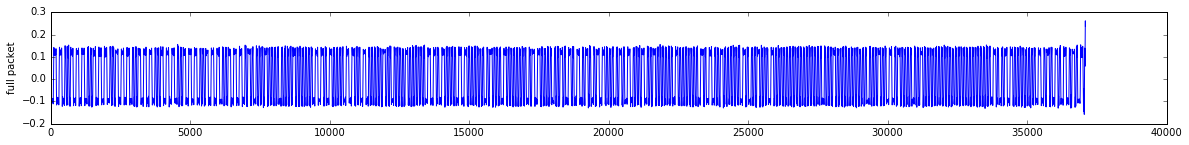

In [116]:
# packet_offsets = [
#     (324848,603305),
#     (936843,1215300),
#     (1548815,1827295),
# ]

# packet_offsets = [
#     (555650, 831650),
#     (1137070, 1160600)
# ]

packet_samples = samples[slice(*packet_offsets[1])]
#packet_samples = samples[5345325:5462093]
plt.figure(figsize=(20,2))
plt.plot(packet_samples)
plt.ylabel('full packet')
plt.show()


### Zoom in

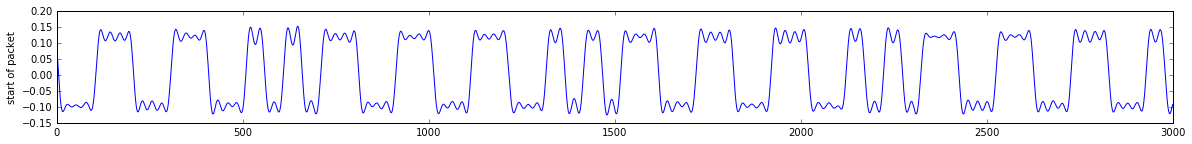

In [117]:
plt.figure(figsize=(20,2))
plt.plot(packet_samples[0:3000])
plt.ylabel('start of packet')
plt.show()


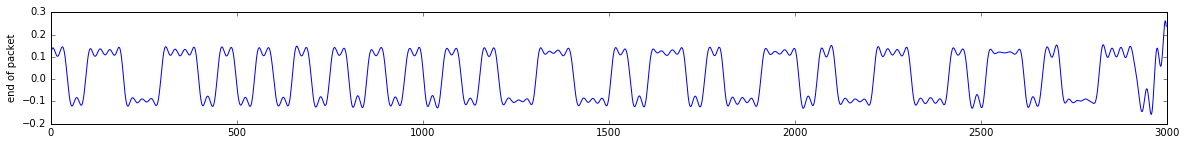

In [118]:
plt.figure(figsize=(20,2))
plt.plot(packet_samples[-3000:])
plt.ylabel('end of packet')
plt.show()

In [119]:
bytes = omni_rf.decode_packet(
        packet_samples,
        samples_per_bit,
        manchester_variant='g_e_thomas',
        preamble_byte=0xab)

#"".join([format(n, '02x') for n in bytes])
bytes

array([128], dtype=uint8)

### Detect bitrate

[102  99 103  99  52  49  51  49 103  99 103  99 102 100  51  49  52  49
 102 100 102 100 102 100  51  49  52  49 102  99 103  99 102 100  52  49
  52  48 103  99 103  99 102 100  51  49  52  49 102 100 102 100 101 101
  51  49  52  49 102  99 103  99 102 100  52  49  52  48 103  99 102 100
 102 100  51  49  52  49 103  99 102 100 102 100  51  49 102  49  52 100
  51  50  51  50  51  49 102  49  52  49  52  49  52  49  51 100  52  49
  51  50  52  49  51  49 103  48  52  50  52  48  52  49  52  49  51  50
  51 100 102 100 102  49  52  99 103  48  52  49  52  49  52  49  51 101
 101 100 102  49  52  49  52  99 103  99  52  49  51  50  51  50  51  49
  52  48 103  49  52  49  52  99  52  49  52  49  52  48  53  49 102  49
  52  49  51  50  51  50  51  50  51  49  51 101 102  99 102  49  52  99
 103  49  51  50  51  50  51  49  52  99 102 100 102  50  51  50  51  49
  52  49  52  48  53  49  51 100  52  48 103  49  52  49  52  48  52 100
 102  49  52  49  52  49  52  48  53  48  52  49  5

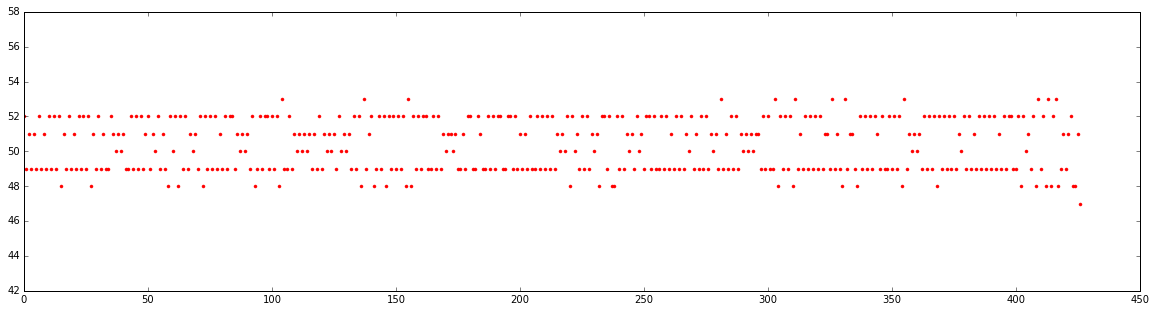

In [120]:
signs = np.array(packet_samples >= 0, int)
differences = np.diff(signs)
#print differences[0:1000]
crossings = np.nonzero((differences < 0) | (differences > 0))[0]
#print crossings
cumulWidths = crossings[1:] - crossings[0]
#print "cumulWidths = %s" % cumulWidths
widths = (cumulWidths[1:] - cumulWidths[:-1])
#plt.hist(widths,bins=30,range=[30,60])
#plt.show()
filtered_widths = widths[(widths > 20) & (widths < 80)]
print widths
samples_per_bit = filtered_widths.mean()
print "avg samples per bit = %s" % samples_per_bit
print "bit rate = %s bps" % (sample_rate/samples_per_bit).round().astype(int)

plt.figure(figsize=(20,5))
plt.ylim(42,58)
plt.plot(filtered_widths,'r.')
plt.show()


In [121]:
# Get phase of signal with the modulo of the bitrate of the first 10 crossings
phase_offset = (crossings[:10] % samples_per_bit).mean()
print "Phase offset = %s" % phase_offset

Phase offset = 3.98969555035


### Sample bits from part of packet

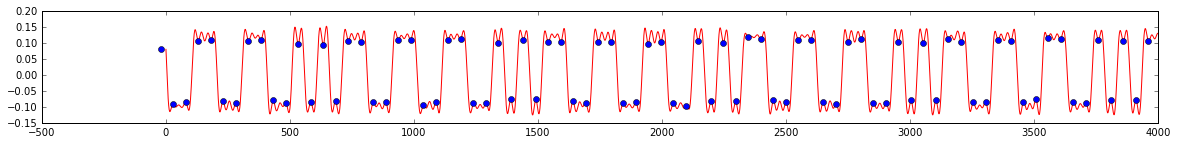

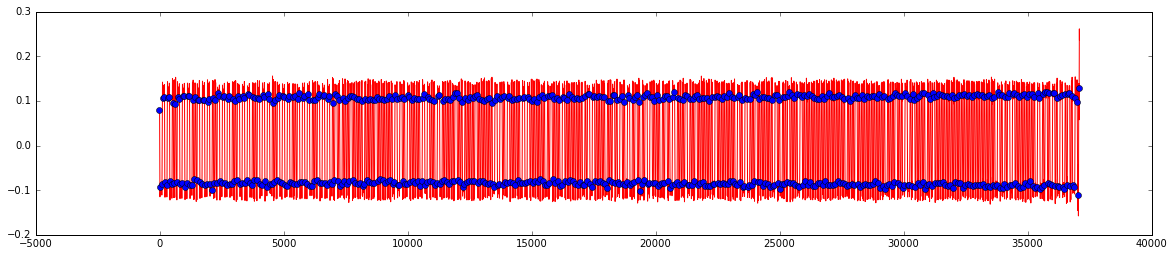

In [122]:
samples_per_bit = 50.41

bit_center_offset = phase_offset - (samples_per_bit / 2.0)

def resample(samples, offset, step):
    centers = np.arange(offset, samples.size, step)
    xp = np.arange(samples.size)
    return (centers, np.interp(centers, xp, samples))

(centers, bits) = resample(packet_samples[:4000], bit_center_offset, samples_per_bit)
plt.figure(figsize=(20,2))
plt.plot(packet_samples[:4000], "r", centers, bits, 'bo')

(centers, bits) = resample(packet_samples, bit_center_offset, samples_per_bit)
plt.figure(figsize=(20,4))
plt.plot(packet_samples, "r", centers, bits, 'bo')


### Get bits for entire packet

In [123]:
(centers, bits) = resample(packet_samples, bit_center_offset, samples_per_bit)
bits = (bits > 0).astype(int)
print "".join(map(str, bits[:80]))

10011001100101011001100110010101100110011001010110011001100101011001100110010101


### Manchester decoding

In [81]:
def manchester_decode(bits, mode='g_e_thomas'):
    decoded = []
    if mode == 'ieee':
        hi_low = 0
        low_hi = 1
    else:
        hi_low = 1
        low_hi = 0
        
    prev = None
    for bit in bits:
        if prev == None:
            prev = bit
            continue
        
        if prev == 0 and bit == 1:
            d = low_hi
            prev = None
        elif prev == 1 and bit == 0:
            d = hi_low
            prev = None
        else:
            d = -1 # Error
            prev = bit
            
        decoded.append(d)
    return np.array(decoded)


In [151]:
print "bits: " + "".join(map(str, bits))
decoded_bits = manchester_decode(bits[0:], 'ieee')
print "manchester decode: " + "".join(map(str, decoded_bits))
decoded_bits = np.trim_zeros(decoded_bits + 1) - 1 # Trim leading and trailing errors
print "decoded size = %s" % decoded_bits.size
print "manchester decode trimmed: " + "".join(map(str, decoded_bits))


bits: 10011001100101011001100110010101100110011001010110011001100101011001100110010101100110011001010110011001100101011001100110010101100110011001011010010101011010101010010101010110101010101010011001101001101010101001100110101001100101010101011010100101010101101010101010100110011010011010101010011001101010101010100101101010100110101010101010100101100110101010100101011010011010011001011010010110011010101001011010011001010101100101011010101010101001101010101010101001101001100101011010101010101001101001010110101010011010101010101010101010101010101010100101010110101010101010101010101001010101101010011001011010101010010101101010101010101010101010101010101010101010101010100110100101100110101010101010101001100101101001101001100101101001101
manchester decode: 010101110101011101010111010101110101011101010111010101110101011101010110011110000011111000000010100100000101000101111110001111100000001010010000010100000001100001000000001101000001110010010110011010000110010111101110000000100000000100101

In [154]:

bytes = np.packbits(decoded_bits[0:])
"".join([format(n, '02x') for n in bytes])

'575757575757575756783e0290517e3e0290501840341c966865ee02012e027080001e001e2c1c000001340164b2'